<a href="https://colab.research.google.com/github/NadAAaHH/SDAIA_T5_deep_learning_project/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Importing libraries

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [2]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization, Conv1D, MaxPooling1D, Bidirectional)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [3]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [4]:
root_captioning = "root_path"

### Step 2: Cleaning the descriptions

In [5]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text',\
                        'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [6]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


### Step 3: Load GloVe embeddings

In [7]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [8]:
len(img)

8091

In [9]:
train_images_path = os.path.join(root_captioning,\
            'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

In [10]:
# display the size of the train and test sets
print(len(train_images))
print(len(test_images))

6000
1000


### Step 4: Building the descriptions

In [11]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [12]:
len(train_descriptions)

6000

In [13]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96124928/96112376 [==============================] - 1s 0us/step


In [14]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Step 5: Creating the train and test set

In [15]:
 def encodeImage(img):
  # Resize all images to a standard size (specified bythe image 
  # encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for 
  # the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [16]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [17]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

In [18]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [19]:
# drop the words with low occurrences
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [20]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [21]:
# consider the START and STOP tokens 
max_length +=2
print(max_length)

34


### Step 6: Build and train our neural network

In [22]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [23]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.42B.300d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

1917495it [03:23, 9439.10it/s] 

Found 1917495 word vectors.


In [24]:
embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [25]:
max_length

34

In [26]:
OUTPUT_DIM

2048

In [27]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Conv1D(32, kernel_size=5, activation='relu')(se2) 
se4 = MaxPooling1D(pool_size=2)(se3) 
se5 = Dropout(0.5)(se4)
se6 = Bidirectional(LSTM(128, return_sequences = True))(se5) 
se7 = Dropout(0.5)(se6)
se8 = LSTM(256)(se7)

decoder1 = add([fe2, se8])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [28]:
embedding_dim

300

In [29]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 300)      495600      ['input_3[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 34, 300)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 30, 32)       48032       ['dropout_1[0][0]']              
                                                                                            

In [30]:
caption_model.layers[1].set_weights([embedding_matrix])
caption_model.layers[1].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [31]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [32]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
if not os.path.exists(model_path):
  start = time()
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

### Step 7: Generating captions

In [33]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Evaluate the perfromance of the model

/content/drive/MyDrive/Flicker8k_Dataset/384577800_fc325af410.jpg


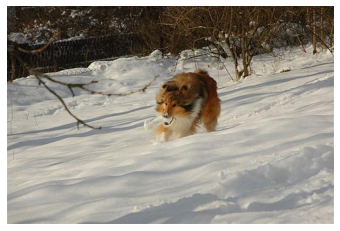

Caption: dog runs in the snow
_____________________________________
/content/drive/MyDrive/Flicker8k_Dataset/387830531_e89c192b92.jpg


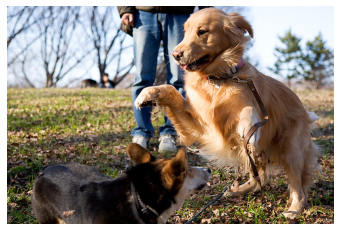

Caption: two dogs are running in the grass
_____________________________________
/content/drive/MyDrive/Flicker8k_Dataset/396360611_941e5849a3.jpg


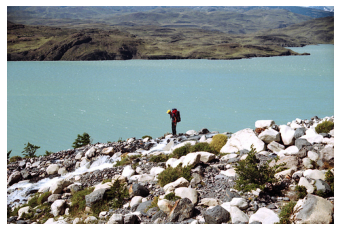

Caption: man stands on the edge of cliff
_____________________________________
/content/drive/MyDrive/Flicker8k_Dataset/391579205_c8373b5411.jpg


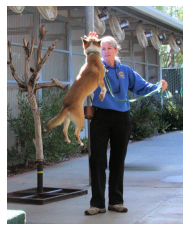

Caption: two boys are playing on the floor
_____________________________________
/content/drive/MyDrive/Flicker8k_Dataset/398662202_97e5819b79.jpg


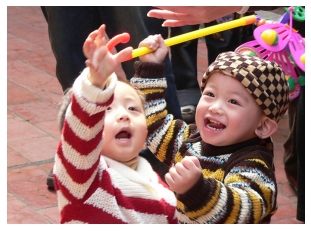

Caption: young girl in pink shirt is playing bubbles
_____________________________________
/content/drive/MyDrive/Flicker8k_Dataset/400851260_5911898657.jpg


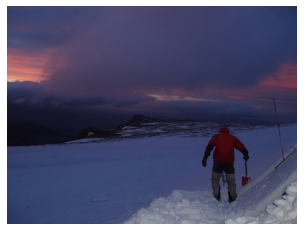

Caption: man in red jacket and blue pants is standing on snowy mountain
_____________________________________
/content/drive/MyDrive/Flicker8k_Dataset/401079494_562454c4d6.jpg


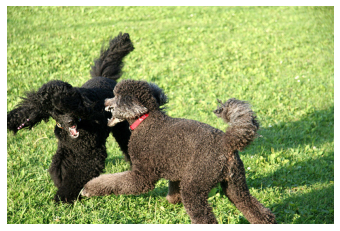

Caption: two dogs are playing in the grass
_____________________________________


In [34]:
for z in range(7): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.axis('off')
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [35]:
encoding_test[pic].shape

(2048,)

Evaluate the model on external images

In [36]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

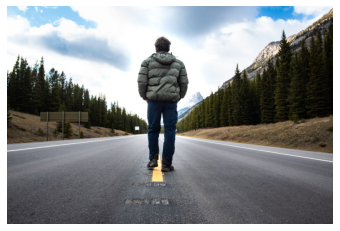

(1, 2048)
Caption: man in red shirt is standing on the of rock
_____________________________________


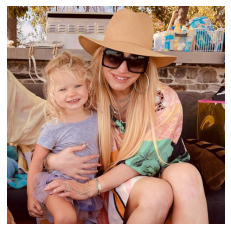

(1, 2048)
Caption: two women in identical pose
_____________________________________


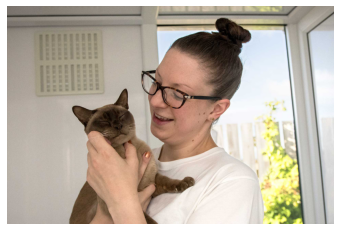

(1, 2048)
Caption: woman in blue shirt is sitting on sofa
_____________________________________


In [37]:
urls = [
        'https://images.unsplash.com/photo-1563555270835-892a9881e7e8?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1000&q=80',
        'https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fstatic.onecms.io%2Fwp-content%2Fuploads%2Fsites%2F20%2F2021%2F05%2F10%2Fjessica-simpson-1-1.jpg',
        'https://www.catseyecattery.co.uk/wp-content/uploads/2018/08/about-harriet2.jpg'
]
for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")

### Step 8: Splitting the video into frames

In [38]:
import cv2
import matplotlib.image as mpimg

In [39]:
# Playing video from file:
cap = cv2.VideoCapture('video_path')

# create directory 
try:
    if not os.path.exists('/content/frames'):
        os.makedirs('/content/frames')
except OSError:
    print ('Error: Creating directory of data')

currentFrame = 0
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret: 
      break 

    # Saves image of the current frame in jpg file
    name = '/content/frames/frame' + str(currentFrame) + '.jpg'
    #print ('Creating...' + name)
    cv2.imwrite(name, frame)

    # To stop duplicate images
    currentFrame += 1

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Testing the model on a frame

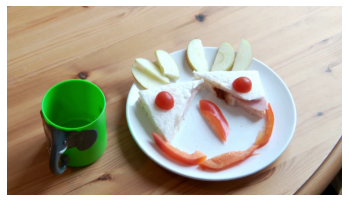

(1, 2048)
Caption: dog is eating in the air


In [40]:
img= Image.open('/content/frames/frame20.jpg')
img.load()

plt.imshow(img)
plt.axis('off')
plt.show()

img = encodeImage(img).reshape((1,OUTPUT_DIM))
print(img.shape)
print("Caption:",generateCaption(img))

Getting different scenes of a video

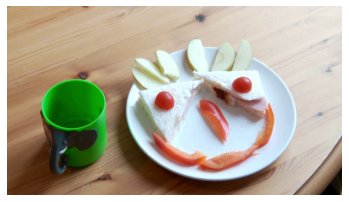

Size of file is 346698 bytes


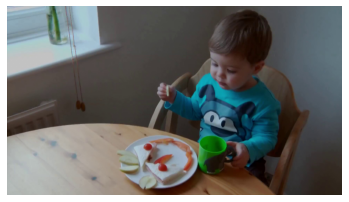

Size of file is 220286 bytes


In [41]:
url1 = '/content/frames/frame22.jpg'
img1= Image.open(url1)
img1.load()

plt.imshow(img1)
plt.axis('off')
plt.show()
size = os.path.getsize(url1) 
print('Size of file is', size, 'bytes')

url2 = '/content/frames/frame70.jpg'
img2= Image.open(url2)
img2.load()

plt.imshow(img2)
plt.axis('off')
plt.show()
size = os.path.getsize(url2) 
print('Size of file is', size, 'bytes')